# Load hdf file and post-process

For a given model (as guitar_model above), set internal data using hdf5 input. Useful for post-processing only. 

Prerequisite : a complete simulation saved in hdf file (e.g. results of run.py)

### Usage: 

* call load_model function : create a model (dynamical system, interactions and so on) and load results from a previous simu from hdf file
* call post-processing tools

In [134]:
# Reload automatically all python modules before each cell exec
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
# standard python packages
import sys
import time
import os
import numpy as np
from model_tools import load_model
# visu
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
import scipy.io
import h5py

## Pick up results file(s)

Either choose one or more campaigns (A)
or explicitely set input file  (B)

In [140]:
# Case (A)
from post_process import compute_errors, plot_campaign, check_time_vectors
import simulation_campaigns
# Set path to matlab inputs
matlab_frets = './bass_guitar/pb2'
matlab_fretless = './fretless_bass_guitar/bsf'
campaigns = {}
campaigns['bass_09'] = (simulation_campaigns.g2017_11_30_e09, matlab_frets)
campaigns['bass_0'] = (simulation_campaigns.g2017_11_30_e0,  matlab_frets)
campaigns['bass_1'] = (simulation_campaigns.g2017_11_30_e1,  matlab_frets)
#campaigns['fretless_09'] = (simulation_campaigns.f2017_11_28_e09,  matlab_fretless)
#campaigns['fretless_0'] = (simulation_campaigns.f2017_11_28_e0, matlab_fretless)

# Case (B)
# filelist = ['./results/F_15680_id_3755969/g_862_15680.h5']

## Convergence study

In [141]:
for name in campaigns:
    filelist = campaigns[name][0]['files_converted']
    check_time_vectors(filelist, matlab_frets)
    #print(filelist, '\n')


Load model from file ./results_bass/2017_11_30/F_64225280_id_3878785/converted_g_862_64225280.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 64225280.0.
Save output every 4096 time steps.
Load model from file ./results_bass/2017_11_30/F_15680_id_3877931/converted_g_862_15680.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 15680.0.
Save output every 1 time steps.
check i ...  0
Load model from file ./results_bass/2017_11_30/F_31360_id_3877930/converted_g_862_31360.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 31360.0.
Save outp

check i ...  9
Load model from file ./results_bass/2017_11_30/F_16056320_id_3877940/converted_g_862_16056320.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 16056320.0.
Save output every 1024 time steps.
check i ...  10
Load model from file ./results_bass/2017_11_30/F_32112640_id_3877939/converted_g_862_32112640.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 32112640.0.
Save output every 2048 time steps.
check i ...  11
Load model from file ./results_bass/2017_11_30/F_64225280_id_3878147/converted_g_862_64225280.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to

In [142]:
# Select a campaign and converted files
errors = {}
#freqs = {}
#ymin = {}
for name in campaigns:
    filelist = campaigns[name][0]['files_converted']
    matlab_input = campaigns[name][1]
    errors[name], ymin[name] = compute_errors(filelist, indices=[10, 400, 800],
                                  from_matlab=matlab_input)
    freqs[name] = campaigns[name][0]['freqs']

Load model from file ./results_bass/2017_11_30/F_64225280_id_3878785/converted_g_862_64225280.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 64225280.0.
Save output every 4096 time steps.
Load model from file ./results_bass/2017_11_30/F_15680_id_3877931/converted_g_862_15680.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 15680.0.
Save output every 1 time steps.
Load model from file ./results_bass/2017_11_30/F_31360_id_3877930/converted_g_862_31360.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 31360.0.
Save output every 2 time

Load model from file ./results_bass/2017_11_30/F_32112640_id_3877939/converted_g_862_32112640.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 32112640.0.
Save output every 2048 time steps.
Load model from file ./results_bass/2017_11_30/F_64225280_id_3878147/converted_g_862_64225280.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 64225280.0.
Save output every 4096 time steps.
Load model from file ./results_bass/2017_11_30/F_15680_id_3878162/converted_g_862_15680.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 15680.0.
Save output 

In [85]:
errors_ok = dict(errors)

In [113]:
errors['bass_1'].shape

(12, 3)

In [114]:
errors['bass_09'] = errors['bass_09'][:-1,:]

### Plot convergence for bass guitar

bass_09 12 13
bass_0 12 13
bass_1 12 13
bass_09 12 13
bass_0 12 13
bass_1 12 13
bass_09 12 13
bass_0 12 13
bass_1 12 13


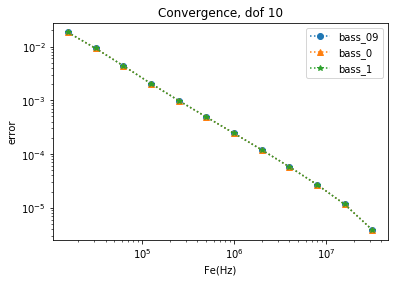

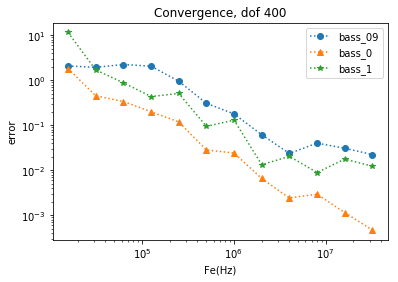

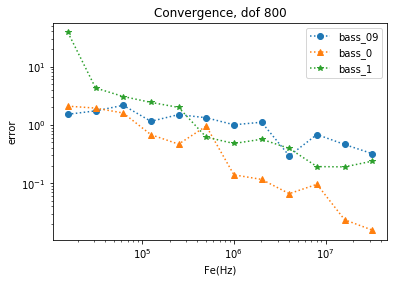

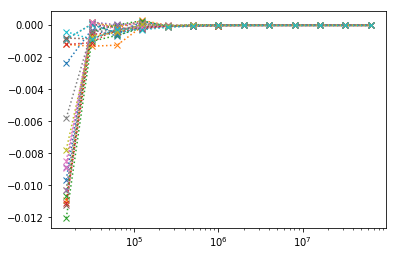

In [143]:
def plot_errors(names, dof, iplot=0):
    plt.figure(iplot)
    ticks = ['o:', '^:', '*:']
    i=0
    leg = []
    for name in names:
        
        ref_error = errors[name]
        ref_freqs = freqs[name]
        print(name, len(ref_error), len(ref_freqs))
        plt.loglog(ref_freqs[:-1], ref_error[:,dof], ticks[i])
        i += 1
        leg.append(name)
    plt.legend(leg)
    plt.xlabel('Fe(Hz)')
    plt.ylabel('error')
    return plt

list_cases = ["bass_09", "bass_0", "bass_1"]
fig = plot_errors(list_cases, 0, 0)
fig.title("Convergence, dof 10")  
plt.savefig("cvg_10.pdf")
fig1 = plot_errors(list_cases, 1, 1)
fig1.title("Convergence, dof 400")  
plt.savefig("cvg_400.pdf")
fig2 = plot_errors(list_cases, 2, 2)
fig2.title("Convergence, dof 800")  
plt.savefig("cvg_800.pdf")



plt.figure(3)
for j in range(ymin[name].shape[1]):
    #plt.plot(freqs[name], ymin[name][:,j])
    plt.semilogx(freqs[name], ymin[name][:,j],'x:')

plt.savefig("min_y.pdf")

### plot simulations durations

In [144]:
def plot_duration(name, tick1, tick2, fig, ax1, ax2):
    duration = np.asarray(campaigns[name][0]['durations']) / 60.
    freqs = campaigns[name][0]['freqs']
    #plt.plot(freqs, duration, tick)
    hosts = campaigns[name][0]['hosts']
    #plt.plot(freqs, host)
    ax1.semilogx(freqs, duration, tick1)
    ax1.set_xlabel('Fe (Hz)')
    ax1.set_ylabel('duration (min)')
    #ax1.tick_params('y', colors='b')
    #ax2 = ax1.twinx()
    ax2.semilogx(freqs, hosts, tick2)
    ax2.set_ylabel('host number')
    #ax2.tick_params('y', colors='r')
    #fig.tight_layout()

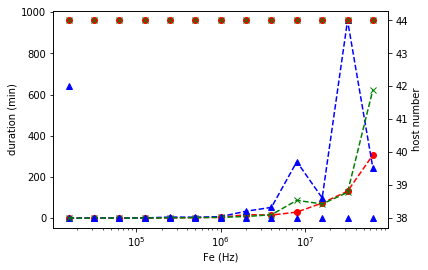

In [145]:
fig0, ax0 = plt.subplots()
ax01 = ax0.twinx()
name = 'bass_0'
plot_duration(name, 'ro--', 'ro', fig0, ax0, ax01)
name = 'bass_09'
plot_duration(name, 'b^--', 'b^', fig0, ax0, ax01)
name = 'bass_1'
plot_duration(name, 'gx--', 'gx', fig0, ax0, ax01)

In [ ]:
fig0, ax0 = plt.subplots()
ax01 = ax0.twinx()
name = 'fretless_0'
plot_duration(name, 'ro--', 'ro', fig0, ax0, ax01)
name = 'fretless_09'
plot_duration(name, 'b^--', 'b^', fig0, ax0, ax01)
name = 'fretless_0_2'
plot_duration(name, 'gx--', 'gx', fig0, ax0, ax01)
name = 'fretless_09_2'
plot_duration(name, 'k*--', 'k*', fig0, ax0, ax01)

In [ ]:
name = 'fretless_0'
ref_error = errors[name]
ref_freqs = freqs[name]
#plt.loglog(ref_freqs[:-1], ref_error[:,0], 'o-')
#plt.loglog(ref_freqs[:-1], ref_error[:,1], '*-')
plt.loglog(ref_freqs[:-1], ref_error[:,1], '+-')

name = 'fretless_09'
ref_error = errors[name]
ref_freqs = freqs[name]
#plt.loglog(ref_freqs[:-1], ref_error[:,0], 'x')
#plt.loglog(ref_freqs[:-1], ref_error[:,1], '^-')
plt.loglog(ref_freqs[:-1], ref_error[:,1], 's-')



## Plot trajectories
Use plotTraj(dynamical_system, list of dof to be plotted)

If list of dof is not set, all dof will be plotted.

Result = dof as a function of time +  zoom specific ranges (as in the paper)

To save the resulting figure(s), add argument filename when calling plotTraj

Arg 'iplot' is used to change figure number. Set same iplot if you want to plot all curves on the same figure.
Default iplot=0.

### Select campaign and required freq

In [129]:
name = 'bass_1'
ifreq = 12
filelist = campaigns[name][0]['files_converted']
matlab_input = campaigns[name][1]
# select a frequency
inputfile = filelist[ifreq]
frets_file = matlab_input + '_h.mat'
all_frets_positions = scipy.io.loadmat(frets_file)['h'][:, 0]

print(inputfile)

./results_bass/2017_11_30/F_64225280_id_3878147/converted_g_862_64225280.h5


In [36]:
inputfile = './g_862_125440.h5'

In [130]:
guitar_model, guitar_string, frets = load_model(inputfile, matlab_input)
#guitar_model.convert_modal_output(guitar_string)
guitar_model._convert[...]=False

Load model from file ./results_bass/2017_11_30/F_64225280_id_3878147/converted_g_862_64225280.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 64225280.0.
Save output every 4096 time steps.


In [124]:
x = np.linspace(0, guitar_string.length, guitar_string.dimension() + 2)
x = x[1:-1]

In [ ]:
inter = frets[1]

In [11]:
inter.contact_index

NameError: name 'inter' is not defined

### Download model, string ...

-0.000883965858218


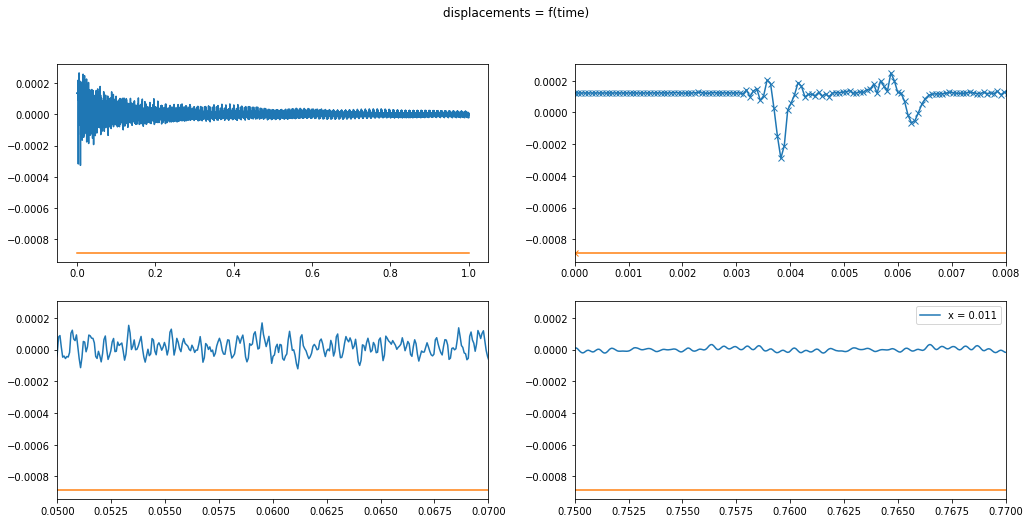

In [146]:
dof = 10
ground = all_frets_positions[dof]# + guitar_string.diameter*0.5
print(ground)
guitar_model.plot_traj(guitar_string, dof=dof, iplot=0, ground=ground)

In [53]:
inter = guitar_model.data_interactions

(0.003, 0.009)

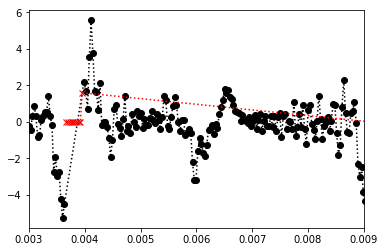

In [48]:
ic = 0
time = guitar_model.time
y = inter[frets[ic]][:,0]
#ydot = inter[frets[ic]][:,1]
#lamb = inter[frets[ic]][:,2]
#plt.plot(time, ydot,'--x')
plt.xlim(0,0.005)
plt.ylim(-10,10)
ind = np.where(y<0)
ind2 = np.where(y>=0)

plt.clf()
#plt.plot(time[ind2], ydot[ind2], 'k:o', time[ind], ydot[ind], 'rx:', )
plt.xlim(0.003, 0.009)

# Plot modes

Use guitar_model.plot_modes(guitar_string,plot_shape)

plot_shape = (x,y) where x,y is the resolution of the grid of plots.

Example: 
plot_modes(guitar_string, (4,2)) : splits time range in 8 and plots dof=f(x) for those 8 time instants on 8 figures


Set filename arg to save resulting figure in a file.

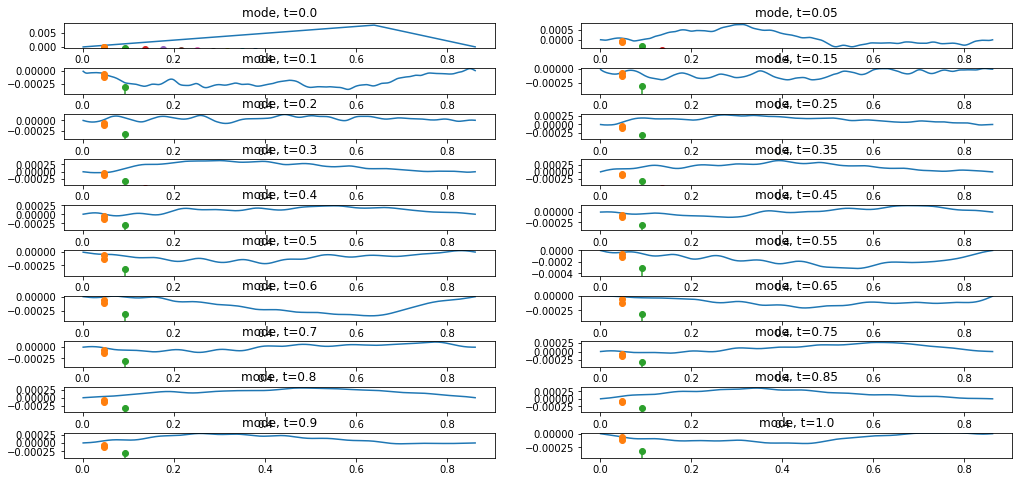

In [52]:
# Plot 10 figures on two columns, for 10 time instants
guitar_model.plot_modes(guitar_string,plot_shape=[10,2], iplot=0)
# Same thing but save output in modes.pdf
#guitar_model.plot_modes(guitar_string,plot_shape=[5,3], filename='modes.pdf', iplot=1)
# plot modes for time[12] and time[5000] on one column
#guitar_model.plot_modes(guitar_string, times =[12, 1200], plot_shape=(2,1), filename='modes2.pdf', iplot=2)

## Create a movie mode=f(time)

In [ ]:
moviename = os.path.basename(filelist[ifreq])
moviename = name + '_'  + os.path.splitext(moviename)[0] + '.mp4'
#moviename = 'tmp.mp4'
guitar_model.make_movie(guitar_string, moviename)

In [ ]:
os.remove('./last.mp4')
os.symlink(moviename, 'last.mp4')

<video controls src="last.mp4" />
#%%html
#<video width="320" height="240" controls>
#  <source src="./last.mp4" type="video/mp4">
#</video>

## Plot contactogram

    !! Works only if enable_interactions_output=True in model (guitar_model) constructor

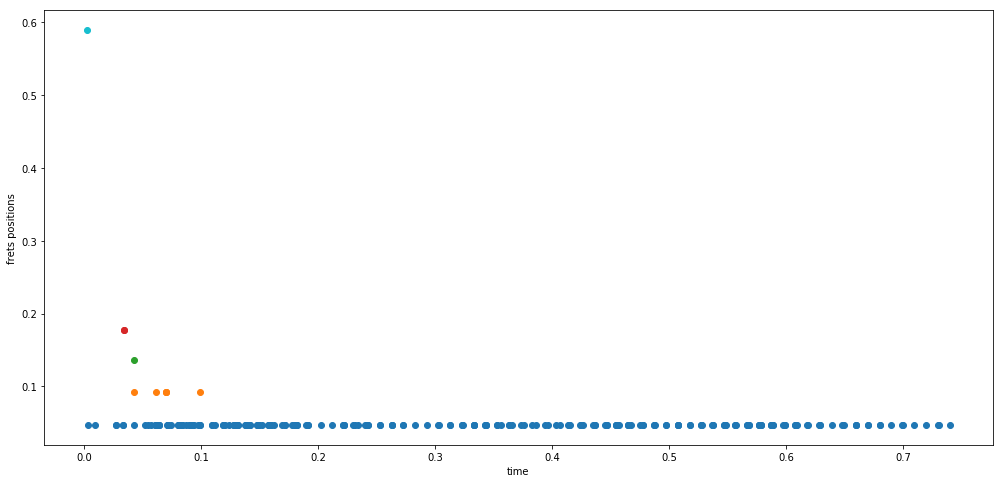

In [132]:
guitar_model.contactogram(guitar_string)
plt.savefig("contacto.pdf")

In [ ]:
15380. / 60. /60.